# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from plotly import express as px

# Load Dataset

In [11]:
med_events = pd.read_csv("med_events.csv")
cols = ["pnr", "eksd", "perday", "ATC", "dur_original"]
med_events.columns = cols
# Convert 'eksd' to datetime (assuming it's in MM/DD/YYYY format)
med_events['eksd'] = pd.to_datetime(med_events['eksd'], format='%m/%d/%Y')

# See Function

In [ ]:
# Define the See function
def See(arg1):
    # Filter data for the specified ATC code
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    
    # Take a random sequence of consecutive prescriptions
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()
    
    # Sort and group by 'pnr'
    Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with NA in 'prev_eksd'
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    
    # Sample one row per 'pnr' (fixing the warning)
    Drug_see_p1 = (Drug_see_p1
                   .groupby('pnr', group_keys=False)[['pnr','eksd','prev_eksd']]
                   .apply(lambda x: x.sample(1,random_state=1234), include_groups=False)
                   .reset_index(drop=True))
    
    # Ensure 'pnr' is included in Drug_see_p1
    if 'pnr' not in Drug_see_p1.columns:
        raise ValueError("The 'pnr' column is missing in Drug_see_p1.")
    
    # Calculate event interval
    Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days
    
    # Calculate ECDF manually
    x = np.sort(Drug_see_p1['event.interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    
    # Create a DataFrame for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain the 20% of the ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Plot ECDF
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(dfper['x'], dfper['y'], label="80% ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, label="100% ECDF")
    plt.title("100% ECDF")
    plt.show()
    
    # Density plot
    ni = dfper['x'].max()
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni]
    sns.kdeplot(np.log(Drug_see_p2['event.interval']), fill=True)
    plt.title("Log(event interval)")
    plt.show()
    
    # DBSCAN Clustering with Silhouette Score Optimization
    # Standardize the data
    X = StandardScaler().fit_transform(dfper[['x']])
    
    # Test a range of eps values
    eps_values = np.linspace(0.01, 1.0, 20)  # Adjust the range as needed
    silhouette_scores = []
    best_score = -1
    best_eps = None
    best_labels = None
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=5)  # Adjust min_samples as needed
        labels = dbscan.fit_predict(X)
        
        # Calculate Silhouette Score (only if more than one cluster is found)
        unique_clusters = np.unique(labels)
        if len(unique_clusters) > 1:
            score = silhouette_score(X, labels)
            silhouette_scores.append(score)
            
            # Track the best configuration
            if score > best_score:
                best_score = score
                best_eps = eps
                best_labels = labels
        else:
            silhouette_scores.append(-1)  # Invalid score for single cluster
    
    # Plot Silhouette Scores vs eps values
    plt.figure(figsize=(8, 6))
    plt.plot(eps_values, silhouette_scores, marker='o')
    plt.axvline(x=best_eps, color='r', linestyle='--', label=f'Best eps: {best_eps:.2f}')
    plt.title("Silhouette Score vs eps for DBSCAN")
    plt.xlabel("eps")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.show()
    
    # Use the best eps value for clustering
    dbscan = DBSCAN(eps=best_eps, min_samples=5)
    dfper['cluster'] = dbscan.fit_predict(X)
    
    # Summarize clusters
    ni2 = dfper.groupby('cluster')['x'].min().reset_index()
    ni3 = dfper.groupby('cluster')['x'].max().reset_index()
    ni4 = dfper.groupby('cluster')['x'].median().reset_index()
    
    nif = pd.merge(ni2, ni3, on='cluster')
    nif = pd.merge(nif, ni4, on='cluster')
    nif.columns = ['Cluster', 'Minimum', 'Maximum', 'Median']
    
    nif['Minimum'] = np.exp(nif['Minimum'])
    nif['Maximum'] = np.exp(nif['Maximum'])
    nif['Median'] = np.exp(nif['Median'])
    
    # Merge results
    results = pd.merge(Drug_see_p1, nif, how='cross')
    
    # Debugging: Print columns of Drug_see_p1 and nif
    # print("Columns in Drug_see_p1:", Drug_see_p1.columns)
    # print("Columns in nif:", nif.columns)
    
    # Ensure 'pnr' is included in the results DataFrame
    if 'pnr' not in results.columns:
        raise ValueError("The 'pnr' column is missing in the results DataFrame. Check the merge operation.")
    
    # Add the 'Final_cluster' column
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']), 
        results['Cluster'], np.nan
    )
    
    # Drop rows with missing 'Final_cluster'
    results = results.dropna(subset=['Final_cluster'])
    
    # Ensure 'pnr' is included in the final selection
    results = results[['pnr', 'Median', 'Cluster']]
    
    # Assign clusters
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='pnr', how='left')
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(results['Median'].median())
    Drug_see_p1['Cluster'] = Drug_see_p1['Cluster'].fillna(-1)  # -1 for noise points
    Drug_see_p1['test'] = round(Drug_see_p1['event.interval'] - Drug_see_p1['Median'], 1)
    
    # Assign Duration
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p1[['pnr', 'Median', 'Cluster']], on='pnr', how='left')
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(results['Median'].median())
    Drug_see_p0['Cluster'] = Drug_see_p0['Cluster'].fillna(-1)  # -1 for noise points
    
    return Drug_see_p0

# See Assumption Function

In [13]:
# Define the see_assumption function
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    Drug_see2 = arg1.groupby('pnr', group_keys=False)[['pnr','eksd','prev_eksd']].apply(lambda x: x.assign(p_number=np.arange(1, len(x) + 1))).reset_index(drop=True)
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2]
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days
    Drug_see2['p_number'] = Drug_see2['p_number'].astype('category')
    
    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(y=medians_of_medians['Duration'].median(), color='r', linestyle='--')
    plt.title("Duration by Prescription Number")
    plt.show()


# Running the Simulation/Analysis

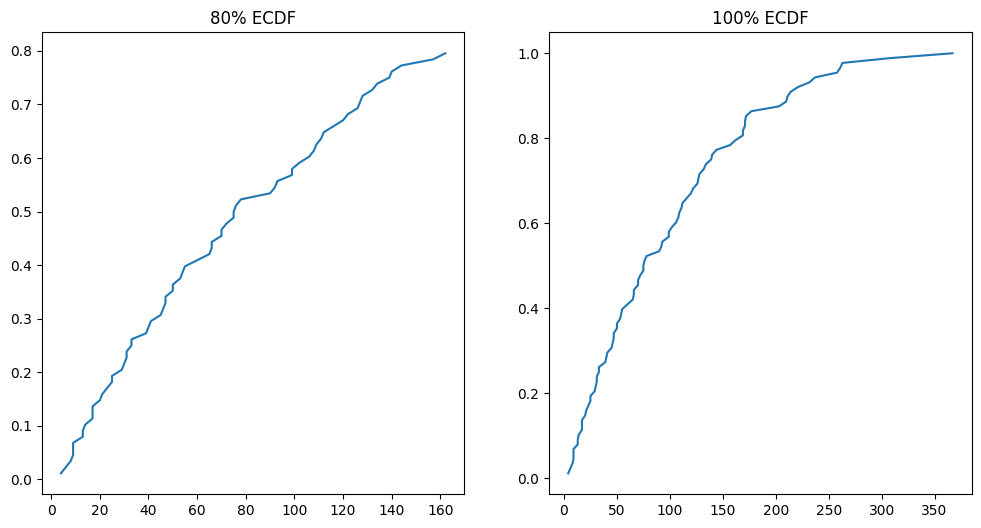

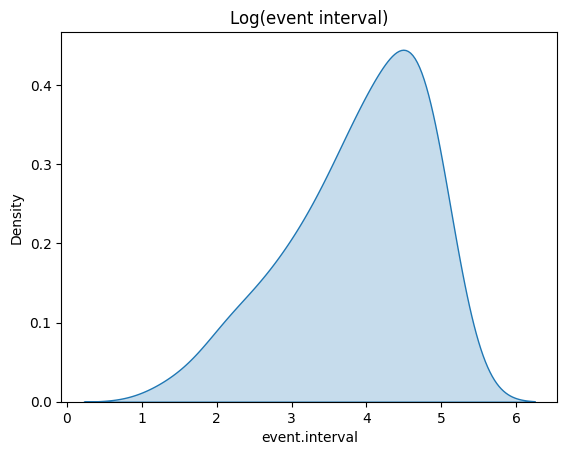

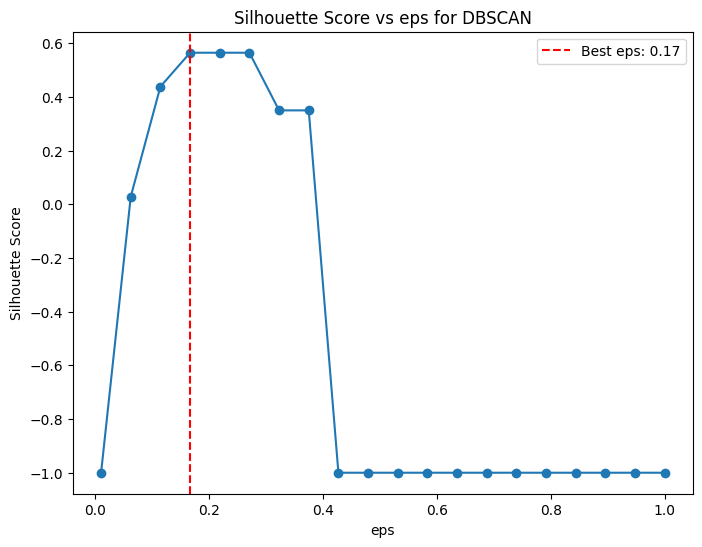

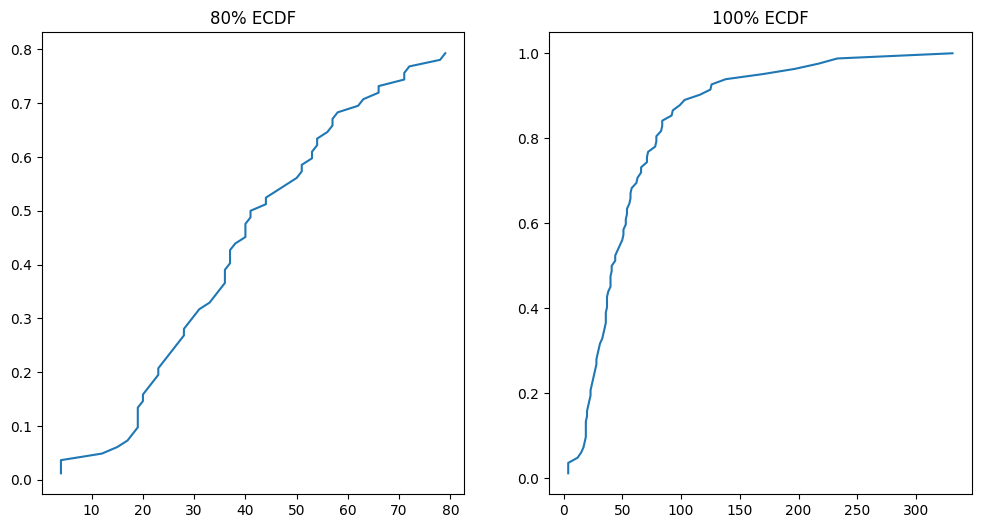

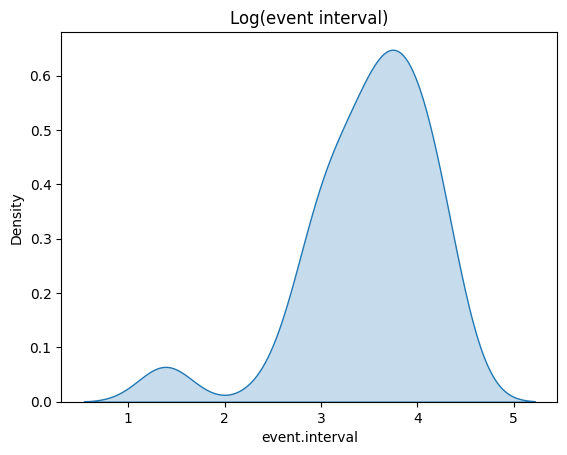

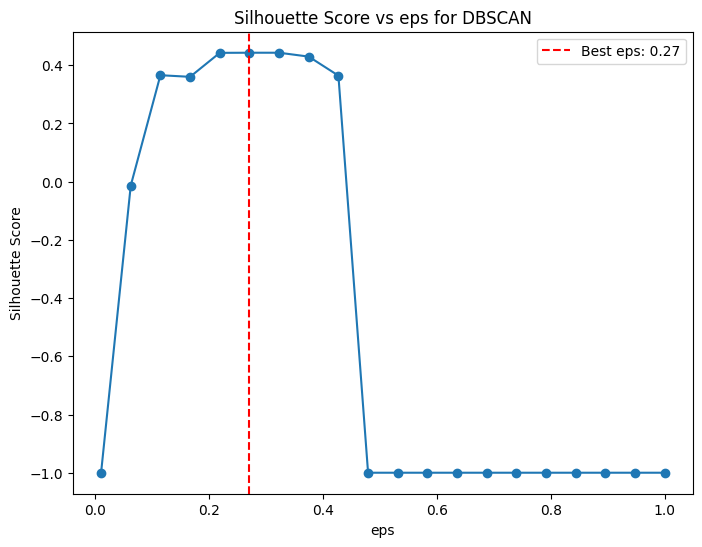

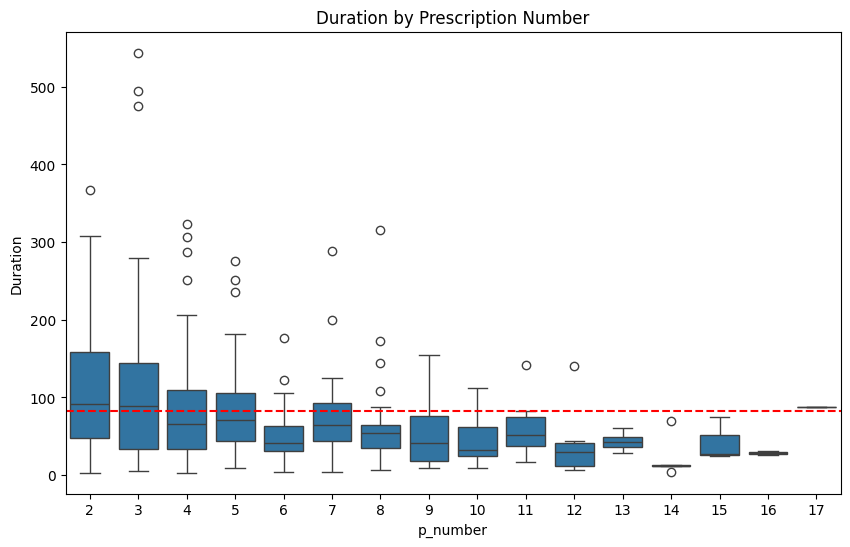

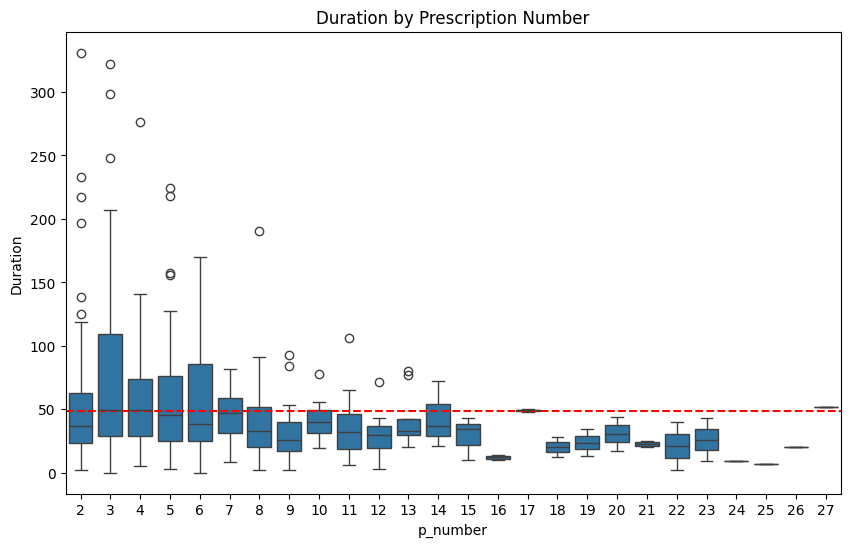

In [14]:
medA = See("medA")
medB = See("medB")

see_assumption(medA)
see_assumption(medB)

# Insights from SEE using DBSCAN

## 1. Cluster Analysis:
- DBSCAN found natural groupings without enforcing a strict number of clusters.  
- Some event intervals were marked as noise (`-1` cluster), meaning they don’t belong to any group.  
- The optimal `eps` value was determined using Silhouette Score.  

## 2. Advantages over K-Means:
- **Handles varying densities better**: Unlike K-Means, DBSCAN can discover clusters of different shapes and densities.  
- **Identifies noise**: Outliers are explicitly labeled instead of being forced into a cluster.  
- **No need to predefine `k`**: The number of clusters emerges from the data instead of being predefined.  

## 3. Limitations:
- DBSCAN struggles when clusters have overlapping densities.  
- Choice of `eps` is critical, and different datasets might require tuning.  

## 4. Observations:
- DBSCAN provided more flexible clustering, avoiding forced assignment of outliers.  
- The clusters found corresponded well to different prescription patterns but had a higher proportion of noise.  
